DCGAN with CelebA dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['TRAINED_MODELS_CONFIG_DIR'] = "/content/gdrive/My Drive/trained_models"

In [ ]:
%pwd

'/content'

In [ ]:
%cd gdrive/My Drive/trained_models

/content/gdrive


In [ ]:
# unzip the zip files and delete the zip files
# !unzip \*.zip  && rm *.zip

In [ ]:
# !mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

In [ ]:
# import zipfile

#with zipfile.ZipFile("celeba.zip","r") as zip_ref:
#  zip_ref.extractall("data_faces/")

In [ ]:
#import os
#root = 'data_faces/img_align_celeba'
#img_list = os.listdir(root)
#print(len(img_list))

In [ ]:
!pwd

/content/gdrive/My Drive/trained_models


In [ ]:
DATA_DIR = "/content/gdrive/My Drive/trained_models/data_faces"

In [ ]:
DATA_DIR

'/content/gdrive/My Drive/trained_models/data_faces'

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(0) 

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
# from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
# usually 1 folder per class
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size), # make image square
                                                      T.ToTensor(), # convert 3 channels x 64 x 64
                                                      T.Normalize(*stats)])) # -1 to 1 range in pixel values

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) # pass-in datasest

In [ ]:
# revert tensor into image
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
# takes image tensors, denormalizes and inserts into grid
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8)) # batch of 64 images and make a grid of the data
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

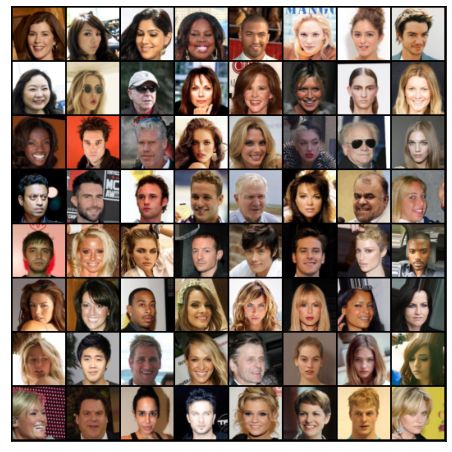

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

Discriminator Network: takes an image as input, tries to classify it as "real" or "generated" ("fake").  Discriminator is like any other NN.  Use a stride of 2 to progressively reduce the size of the output feature map.

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    # stride means output of 1/2 pixels, larger kernel size works quite well (the kernel is swept across the input, subsampling it)
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), 
    nn.BatchNorm2d(64),
    # if input is >0, keep input (reLU removes all negative values, leaky a little bit, 0.02x, to avoid vanashing gradient/ mode collapse)
    nn.LeakyReLU(0.2, inplace=True), 
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), # put convolution above the image, no stride needed
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid() # reduces to probability that the image is from the real dataset and not generated
)

In [ ]:
discriminator = to_device(discriminator, device)

Generator: input is a noise vector, z (a latent tensor), which is used as a seed for generating an image.  Generator converts a latent tensor of shape (128, 1, 1) into an image tensor shape 3 x 64 x 64.  We used ConvTranspose2d layer from PyTorch, a transposed convolution.

In a convolution, we take an image and slide a kernel over it to create an output.  The transposed convolution (Deconvolution) takes for example, a 3 x 3 image and adds space between and around the pixels of the image (outermap) and gives an output.  

Takes numbers and converts into an image.

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    # discriminator is part of the loss for function - we don't want values lost in the discriminator, but not fussed about generator
    nn.ReLU(True), 
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # range -1 to 1
    nn.Tanh()
    # out: 3 x 64 x 64
)

Reason for TanH: "a bounded activation allowed the model to learn more quickly to saturate and cover the colour space of the training distribution.  Within the discriminator, we found the leak rectified activation (Mass et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modelling."

Since the outputs of the TanH activation lie in the range[-1,1], we have applied the similar transformation to the images in the training dataset.  

torch.Size([128, 3, 64, 64])


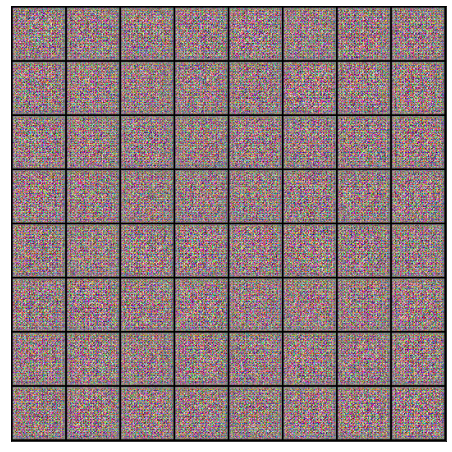

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # batch of random latent tensors of size 3 x 64 x 64
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

We need to train the genenator to create images of human faces.

In [ ]:
generator = to_device(generator, device)

Discriminator Training: we can use binary cross entropy loss function to quantify its performance (similar to a NN)

In [ ]:
def train_discriminator(real_images, opt_d):
  # clear discriminator gradients (the discriminator is used for training generator, there may be left overs)
  opt_d.zero_grad()

  # pass real images
  real_preds = discriminator(real_images) # 3 x 64 x 64 batch
  real_targets = torch.ones(real_images.size(0), 1, device=device) # needs to predict "1", create a tensor of all ones
  real_loss = F.binary_cross_entropy(real_preds, real_targets) # calculate loss
  real_score = torch.mean(real_preds).item() # what was the average score for real images? # begins 0.5 probability initially

  # generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device) 
  fake_images = generator(latent) # converts numbers into images

  # pass fake images to discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device) # needs to predict "0", create a tensor of all zeros
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item() # begins 0.5 probability initially

  # update discriminator weights (back prop)
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step() # performs gradient descent
  return loss.item(), real_score, fake_score # return average score for real images and fake images

We are using the genertor to generate fake images; however, while we train the discriminator, we do not touch the weights of the genertor.  The optimizer for the discriminator only affects the parameters of the discriminator.

Generator Training: we use the discriminator as a part of the loss function.

1. we generate a batch of images using the generator, pass into the discriminator

2. we calculate the loss by setting the target labels to 1 (real).  We do this because the generator's objective is to 'fool' the discriminator.

3. we use the loss to perform gradient descent, changing the weights of the generator, so it gets better at generating the real-like images to 'fool' the discriminator

In [ ]:
def train_generator(opt_g):
  # clear generator gradients
  opt_g.zero_grad()

  # generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

If discriminator loss is too low, it may mean the generator is bad.

If generator loss is too low, it may mean the discriminator is bad.

Unable to evaluate at this time; so we should inspect visually

In [ ]:
# create a directory to save intermediate outputs from the generator to visually inspect the performance of the model
# also create a helper function to export the generated images
from torchvision.utils import save_image

In [ ]:
SAMPLE_DIR = "generated081120"
os.makedirs(SAMPLE_DIR, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = "generated-images-{0:0=4d}.png".format(index)
  save_image(denorm(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow=8)
  print("Saving", fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
!pwd

/content/gdrive/My Drive/trained_models


In [ ]:
# use a fixed set of input vectors to the generator to see how the individual images evolve each epoch
# save one set of images before training starts (similar to keeping validation set fixed)

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device) # 64 fixed latent vectors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


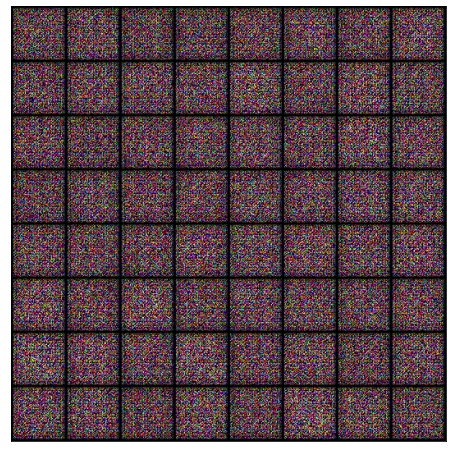

In [ ]:
save_samples(0, fixed_latent)

Full Training Loop: define a fit function to train the discriminator and generator in tandem for each batch of training data.  Using the Adam optimizer with custom parameters (beta) that work well for GANs.  

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache() # cuda otherwise

  # losses and scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      # train generator
      loss_g = train_generator(opt_g)

    # record losses and scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # log losses and scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
      epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
  
    # save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

In [ ]:
# try different learning rates to maintain balance between training the generator and the discriminator
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)


Epoch [1/25], loss_g: 5.8230, loss_d: 1.3374, real_score: 0.8760, fake_score: 0.6249
Saving generated-images-0001.png



Epoch [2/25], loss_g: 1.8059, loss_d: 0.5387, real_score: 0.6972, fake_score: 0.1085
Saving generated-images-0002.png



Epoch [3/25], loss_g: 1.8011, loss_d: 0.6928, real_score: 0.5194, fake_score: 0.0234
Saving generated-images-0003.png



Epoch [4/25], loss_g: 2.4688, loss_d: 0.8930, real_score: 0.9136, fake_score: 0.4841
Saving generated-images-0004.png



Epoch [5/25], loss_g: 2.9787, loss_d: 0.5045, real_score: 0.8348, fake_score: 0.2357
Saving generated-images-0005.png



Epoch [6/25], loss_g: 0.3775, loss_d: 3.4136, real_score: 0.0513, fake_score: 0.0096
Saving generated-images-0006.png



Epoch [7/25], loss_g: 0.8454, loss_d: 0.4682, real_score: 0.6889, fake_score: 0.0637
Saving generated-images-0007.png



Epoch [8/25], loss_g: 2.2820, loss_d: 0.2518, real_score: 0.8682, fake_score: 0.0909
Saving generated-images-0008.png



Epoch [9/25], loss_g: 1.1823, loss_d: 0.3872, real_score: 0.6946, fake_score: 0.0162
Saving generated-images-0009.png



Epoch [10/25], loss_g: 0.7949, loss_d: 0.6996, real_score: 0.6680, fake_score: 0.1766
Saving generated-images-0010.png



Epoch [11/25], loss_g: 0.4664, loss_d: 0.4378, real_score: 0.6905, fake_score: 0.0266
Saving generated-images-0011.png



Epoch [12/25], loss_g: 0.5680, loss_d: 0.3995, real_score: 0.6982, fake_score: 0.0243
Saving generated-images-0012.png



Epoch [13/25], loss_g: 0.0854, loss_d: 1.2614, real_score: 0.5089, fake_score: 0.2071
Saving generated-images-0013.png



Epoch [14/25], loss_g: 4.0795, loss_d: 0.0738, real_score: 0.9693, fake_score: 0.0398
Saving generated-images-0014.png



Epoch [15/25], loss_g: 3.2961, loss_d: 0.1227, real_score: 0.9251, fake_score: 0.0398
Saving generated-images-0015.png



Epoch [16/25], loss_g: 2.7120, loss_d: 0.1764, real_score: 0.8915, fake_score: 0.0533
Saving generated-images-0016.png



Epoch [17/25], loss_g: 1.4292, loss_d: 0.7619, real_score: 0.6218, fake_score: 0.0327
Saving generated-images-0017.png



Epoch [18/25], loss_g: 4.3546, loss_d: 0.3010, real_score: 0.9491, fake_score: 0.1919
Saving generated-images-0018.png



Epoch [19/25], loss_g: 2.5826, loss_d: 0.7073, real_score: 0.7273, fake_score: 0.2533
Saving generated-images-0019.png



Epoch [20/25], loss_g: 4.9237, loss_d: 0.1896, real_score: 0.9294, fake_score: 0.0979
Saving generated-images-0020.png



Epoch [21/25], loss_g: 2.7841, loss_d: 0.1578, real_score: 0.9169, fake_score: 0.0653
Saving generated-images-0021.png



Epoch [22/25], loss_g: 0.3980, loss_d: 1.2751, real_score: 0.4725, fake_score: 0.0540
Saving generated-images-0022.png



Epoch [23/25], loss_g: 9.6618, loss_d: 3.3596, real_score: 0.9985, fake_score: 0.9083
Saving generated-images-0023.png



Epoch [24/25], loss_g: 1.2144, loss_d: 0.7657, real_score: 0.5703, fake_score: 0.0049
Saving generated-images-0024.png



Epoch [25/25], loss_g: 5.4185, loss_d: 0.3536, real_score: 0.8909, fake_score: 0.1650
Saving generated-images-0025.png


In [ ]:
losses_g, losses_d, real_score, fake_score = history

In [ ]:
# save the model checkpoints

torch.save(generator.state_dict(), "G.ckpt")
torch.save(discriminator.state_dict(), "D.ckpt")

In [ ]:
from IPython.display import Image

In [ ]:
!pwd

/content/gdrive/My Drive/trained_models


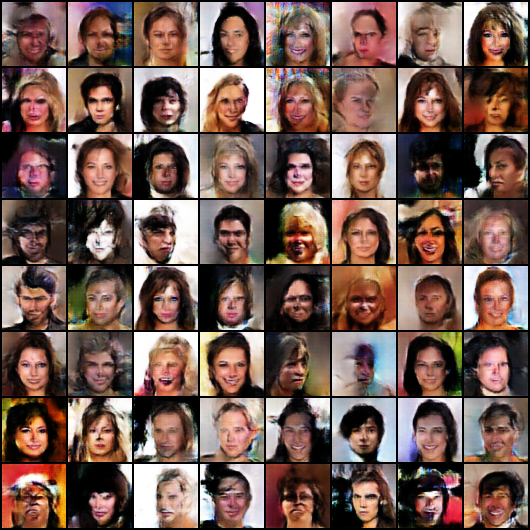

In [ ]:
Image("/content/gdrive/My Drive/trained_models/generated081120/generated-images-0005.png")

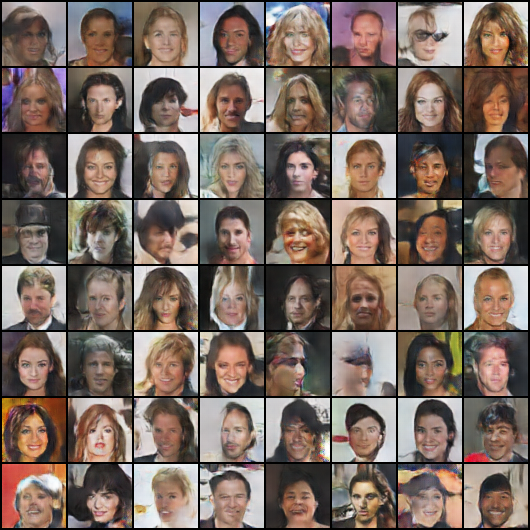

In [ ]:
Image("/content/gdrive/My Drive/trained_models/generated081120/generated-images-0018.png")

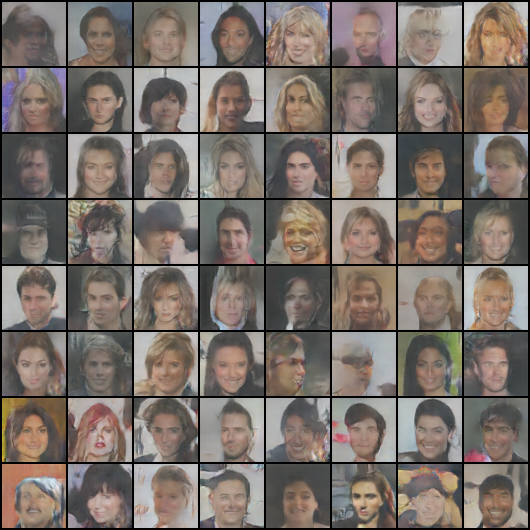

In [ ]:
Image("/content/gdrive/My Drive/trained_models/generated081120/generated-images-0025.png")